In [1]:
import base64
import boto3
from datetime import datetime
from io import BytesIO
import json
import numpy as np
from PIL import Image
import sagemaker
from sagemaker.tensorflow import TensorFlowModel
import tarfile
import tensorflow as tf
import time
import os

In [2]:
## sagemaker configuration
sm_client = boto3.client('sagemaker')
sm_session = sagemaker.Session()
sm_role = sagemaker.get_execution_role()
bucket = sm_session.default_bucket()
s3_client = boto3.client('s3')

In [3]:
## load label dictionary
with open("../data/label_dictionary.json", "r") as f:
    label_dictionary = json.load(f)
with open("../data/inverted_label_dictionary.json", "r") as f:
    inverted_label_dictionary = json.load(f)

## Get model output location
In the cell below, we will pull the trained model that was launched in the previous notebook. After training, the model is stored in S3, and its URI can be found in the SageMaker console by clicking on `Training Jobs` on the left-hand frame, then clicking on the training job, then finally scrolling down to the `Output` section where you will find `S3 model artifact` (see images below for reference).

The S3 key of the model artifact will be assigned to the variable `s3key_model_artifact` in this notebook.

<img src="../images/training_job_panel.png" align="left" width="200"/>
<img src="../images/training_job_list.png" align="center" width="650"/>
<img src="../images/model_output_s3uri.png" align="center" width="650"/>

### Local inference

In [4]:
## get the output path of the training job
# pull the path from the training job using the sagemaker client
s3uri_model_artifact = sm_client.describe_training_job(
    TrainingJobName='cinic-demo-horovod-2021-02-12-20-05-02-420')['ModelArtifacts']['S3ModelArtifacts']
s3key_model_artifact = '/'.join(s3uri_model_artifact.split('/')[3:])

# or find output path in the console using the instructions in the figure above
base_prefix = 'distributed_training_demo/model'
# s3key_model_artifact = f'{base_prefix}/cinic-demo-horovod-2021-02-12-20-05-02-420/output/model.tar.gz'

In [5]:
## download model
local_model_dir = '../data/models'
os.makedirs('../data/models', exist_ok=True)
s3_client.download_file(bucket, s3key_model_artifact, local_model_dir +'/'+ 'horovod_model.tar.gz')

In [6]:
## untar and load models
tar_filepath = os.path.join(local_model_dir, 'horovod_model.tar.gz')
extracted_dir = os.path.join(local_model_dir, 'horovod_model')
with tarfile.open(tar_filepath) as tarred_file:
    tarred_file.extractall(extracted_dir)
model_path = os.path.join(extracted_dir, 'cinic10_classifier', '1')
model = tf.keras.models.load_model(model_path)

In [7]:
## load test dataset for evaluation

test_path = f'../data/sharded_tfrecords/test/'
files = [os.path.join(r,file) for r,d,f in os.walk(test_path) for file in f]
test_set = tf.data.TFRecordDataset(files)

def _dataset_parser(value):
    
    # create a dictionary describing the features    
    sample_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    # parse to tf
    example = tf.io.parse_single_example(value, sample_feature_description)
    
    # decode from bytes to tf types
    # NOTE: example key must match the name of the Input layer in the keras model
    example['image'] = tf.io.decode_raw(example['image'], tf.uint8)
    example['image'] = tf.reshape(example['image'], (32,32,3))
    
    # preprocess for resnset
    # see https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input
    example['image'] = tf.cast(example['image'], tf.float32)
    example['image'] = tf.keras.applications.resnet_v2.preprocess_input(example['image'])
    
    # parse for input to neural network and loss function
    sample_data = {'image_input': example['image']}

    label = tf.cast(example['label'], tf.int32)
    label = tf.one_hot(indices=label, depth=10)
    
    return sample_data, label

test_set = test_set.map(_dataset_parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_set = test_set.batch(128)

In [8]:
## inference on test set
_ = model.evaluate(test_set)

211/211 [==============================] - 41s 196ms/step - loss: 0.7631 - categorical_accuracy: 0.7422


## Real-time endpoint inference

In [9]:
%%time
## create model for batch transform (can also be used for real-time inference)
endpoint_name = 'cinic-10-classifier'
model_name = endpoint_name
instance_type = 'ml.g4dn.xlarge'

## if specifying the exact container, use "image_uri"
# https://github.com/aws/deep-learning-containers/blob/master/available_images.md
image_uri = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-gpu-py37-cu102-ubuntu18.04'

## if specifying only the framework version, for which the container is subject to change, use "framework_version"
# https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model
framework_version = '2.3'

## create model and deploy
sm_model = TensorFlowModel(
    model_data=f's3://{bucket}/{s3key_model_artifact}',
    image_uri=image_uri,
#     framework_version=framework_version,
    source_dir='../source_directory/inference',
    entry_point='inference.py',
    role=sm_role,
    sagemaker_session=sm_session,
    name=endpoint_name,
)

sm_predictor = sm_model.deploy(
    instance_type=instance_type,
    initial_instance_count=1,
    endpoint_name=endpoint_name,
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Using already existing model: cinic-10-classifier


---------------!CPU times: user 25.3 s, sys: 2.39 s, total: 27.7 s
Wall time: 8min


In [10]:
## setup to invoke endpoint
sm_runtime_client = boto3.client('sagemaker-runtime')
image_np = np.random.randint(low=0, high=255, size=(32,32,3))
image_list = image_np.tolist()
image_json = json.dumps(image_list)

In [11]:
## invoke endpoint for inference
response = sm_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=image_json,
    ContentType="application/json",
)
endpoint_vector = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]

In [12]:
## local inference
image_np = np.expand_dims(image_np, axis=0)
local_vector = model.predict(tf.keras.applications.resnet_v2.preprocess_input(image_np))
local_vector = local_vector.tolist()[0]

In [13]:
## check where (if) the endpoint prediction and local prediction disagree
rtol = 1e-5
not_close_idx = np.where(np.isclose(endpoint_vector, local_vector, rtol=rtol) == False)[0]
for i in not_close_idx:
    print("Component {} does not agree:".format(i))
    print("\tendpoint_vector: {}".format(endpoint_vector[i]))
    print("\tlocal_vector: {}".format(local_vector[i]))
if not_close_idx.size < 1:
    print("All elements are within relative tolerance of {}".format(rtol))

All elements are within relative tolerance of 1e-05


In [14]:
## delete endpoint and model
sm_predictor.delete_endpoint()
sm_predictor.delete_model()

## Batch job inference

In [15]:
%%time
env = {'SAGEMAKER_TFS_ENABLE_BATCHING': 'true',
      'SAGEMAKER_TFS_BATCH_TIMEOUT_MICROS': '50000',
      'SAGEMAKER_TFS_MAX_BATCH_SIZE': '16'}

sm_model_transformer = sm_model.transformer(
    instance_count=2,
    strategy='SingleRecord',
    instance_type='ml.p3.2xlarge',
    max_concurrent_transforms=64,
    output_path=f's3://{bucket}/distributed_training_demo/batch_transform_output/',
    env=env,
    assemble_with='Line')

sm_model_transformer.transform(
    data=f's3://{bucket}/distributed_training_demo/data/test/',
    data_type='S3Prefix',
    split_type='TFRecord',
    content_type='application/x-tfexample',
    wait=True,
    logs=False,)

........................................................................................................!
CPU times: user 25.8 s, sys: 2.38 s, total: 28.2 s
Wall time: 9min 7s


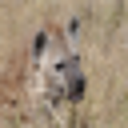

dog


In [20]:
## parse and confirm data in tfrecords

test_index = 21

# load and test the tf record files
test_image_s3key = 'distributed_training_demo/data/test/test_000.tfrecords'
test_set = tf.data.TFRecordDataset(f's3://{bucket}/{test_image_s3key}')

# Create a dictionary describing the features.
sample_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_sample_function(example_proto):
    return tf.io.parse_single_example(example_proto, sample_feature_description)

test_set = test_set.map(_parse_sample_function)
test_set = test_set.batch(1)
for i, sample_features in enumerate(test_set):
    image = tf.io.decode_raw(sample_features['image'], tf.uint8)
    image = tf.reshape(image, (32,32,3))
    
    label = sample_features['label']
    
    if i==test_index: break

display(Image.fromarray(image.numpy()).resize((128,128)))
print(inverted_label_dictionary[str(int(label.numpy()))])

In [21]:
## local inference
processed_image = tf.reshape(tf.keras.applications.resnet_v2.preprocess_input(image.numpy()), (1,32,32,3))
local_vector = model.predict(processed_image)[0]
local_prediction = np.argmax(local_vector)
print(inverted_label_dictionary[str(int(local_prediction))])

dog


In [22]:
## get inference from batch transform job
test_image_s3key = 'distributed_training_demo/batch_transform_output/test_000.tfrecords.out'
bt_inference = s3_client.get_object(Bucket=bucket, Key=test_image_s3key)
predictions = bt_inference['Body'].read().decode("utf-8")
bt_vector = np.array(json.loads(predictions.split()[test_index])['predictions'][0])
bt_prediction = np.argmax(bt_vector)
print(inverted_label_dictionary[str(int(bt_prediction))])

dog


In [23]:
## check where (if) the endpoint prediction and local prediction disagree
rtol = 1e-5
not_close_idx = np.where(np.isclose(local_vector, bt_vector, rtol=rtol) == False)[0]
for i in not_close_idx:
    print("Component {} does not agree:".format(i))
    print("\tendpoint_vector: {}".format(endpoint_vector[i]))
    print("\tlocal_vector: {}".format(local_vector[i]))
if not_close_idx.size < 1:
    print("All elements are within relative tolerance of {}".format(rtol))

All elements are within relative tolerance of 1e-05
